<a href="https://colab.research.google.com/github/SknyL/Face_emotion_recognition/blob/main/Train_FER_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка датасета

In [44]:
!gdown 1V-ZnDOA8nqpNXpi_gg18v3tDX2lSMU9F

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1V-ZnDOA8nqpNXpi_gg18v3tDX2lSMU9F 



In [1]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/croped_train.zip' -d '/content/data/'

Загрузка скрипта с моделью классификации

In [10]:
!mkdir /content/models/
!wget -O /content/models/class_model.py 'https://github.com/SknyL/Face_emotion_recognition/blob/2c61d9e09fa756ccb90160de9ac4c94483192b2a/train_model/models/class_model.py?raw=true'

--2023-03-12 14:57:20--  https://github.com/SknyL/Face_emotion_recognition/blob/2c61d9e09fa756ccb90160de9ac4c94483192b2a/train_model/models/class_model.py?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SknyL/Face_emotion_recognition/raw/2c61d9e09fa756ccb90160de9ac4c94483192b2a/train_model/models/class_model.py [following]
--2023-03-12 14:57:20--  https://github.com/SknyL/Face_emotion_recognition/raw/2c61d9e09fa756ccb90160de9ac4c94483192b2a/train_model/models/class_model.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SknyL/Face_emotion_recognition/2c61d9e09fa756ccb90160de9ac4c94483192b2a/train_model/models/class_model.py [following]
--2023-03-12 14:57:21--  https://raw.githubusercontent.com/SknyL/Face_emotion_recognition/2c61d9e09fa7

In [73]:
execfile('/content/models/class_model.py')

Создание dataflow для обучения модели классификации

In [2]:
image_size = (48,48)
batch_size = 32
train_path = '/content/data/content/data/croped_train'

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range=15,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                horizontal_flip=True,
                                                                validation_split=0.2,
                                                                fill_mode='nearest')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          validation_split = 0.2)

In [6]:
train_dataflow = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    subset='training',
                                                    interpolation='bilinear',
                                                    keep_aspect_ratio=True)

valid_dataflow = valid_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    subset='validation',
                                                    interpolation='bilinear',
                                                    keep_aspect_ratio=True)

Found 36875 images belonging to 9 classes.
Found 9214 images belonging to 9 classes.


Загрузка предобученных весов модели (если они есть)

In [14]:
!mkdir /content/models/weights
!wget -O /content/models/weights/model_class_weights.h5 'https://github.com/SknyL/Face_emotion_recognition/blob/main/train_model/models/weights/model_class_weights.h5?raw=true'

mkdir: cannot create directory ‘/content/models/weights’: File exists
--2023-03-12 14:58:45--  https://github.com/SknyL/Face_emotion_recognition/blob/main/train_model/models/weights/model_class_weights.h5?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SknyL/Face_emotion_recognition/raw/main/train_model/models/weights/model_class_weights.h5 [following]
--2023-03-12 14:58:45--  https://github.com/SknyL/Face_emotion_recognition/raw/main/train_model/models/weights/model_class_weights.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SknyL/Face_emotion_recognition/main/train_model/models/weights/model_class_weights.h5 [following]
--2023-03-12 14:58:46--  https://raw.githubusercontent.com/SknyL/Face_emotion_recognition/main/train_model/model

In [15]:
path_weights = 'models/weights/model_class_weights.h5'

In [74]:
# Создание модели
class_model = FER_class_model(path_model_weights=path_weights)

Model: "FER_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0 

In [19]:
# callback для сохранения весов после каждой эпохи
mcp = tf.keras.callbacks.ModelCheckpoint('weights/trained_model_class_weights.h5',
                                       monitor='val_mean_absolute_error',
                                       verbose=1,
                                       save_best_only=False,
                                       save_weights_only=True,
                                       save_freq='epoch',
                                       mode='min')

In [ ]:
# Компилирование и обучение модели
my_optimiser = tf.keras.optimizers.Adam(
                learning_rate=0.001, 
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-07, 
                amsgrad=False)
class_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=my_optimiser)
class_model.fit(train_dataflow,
                validation_data=valid_dataflow,
                epochs=50,
                steps_per_epoch=2*len(train_dataflow),
                callbacks=[mcp])

Проверка работы модели

In [43]:
import matplotlib.pyplot as plt

In [59]:
emotion_dict = {'anger': 0,
                'contempt': 1,
                'disgust': 2,
                'fear': 3,
                'happy': 4,
                'neutral': 5,
                'sad': 6,
                'surprise': 7,
                'uncertain': 8}
emotion_dict = dict((v,k) for k, v in zip(emotion_dict.keys(), emotion_dict.values()))

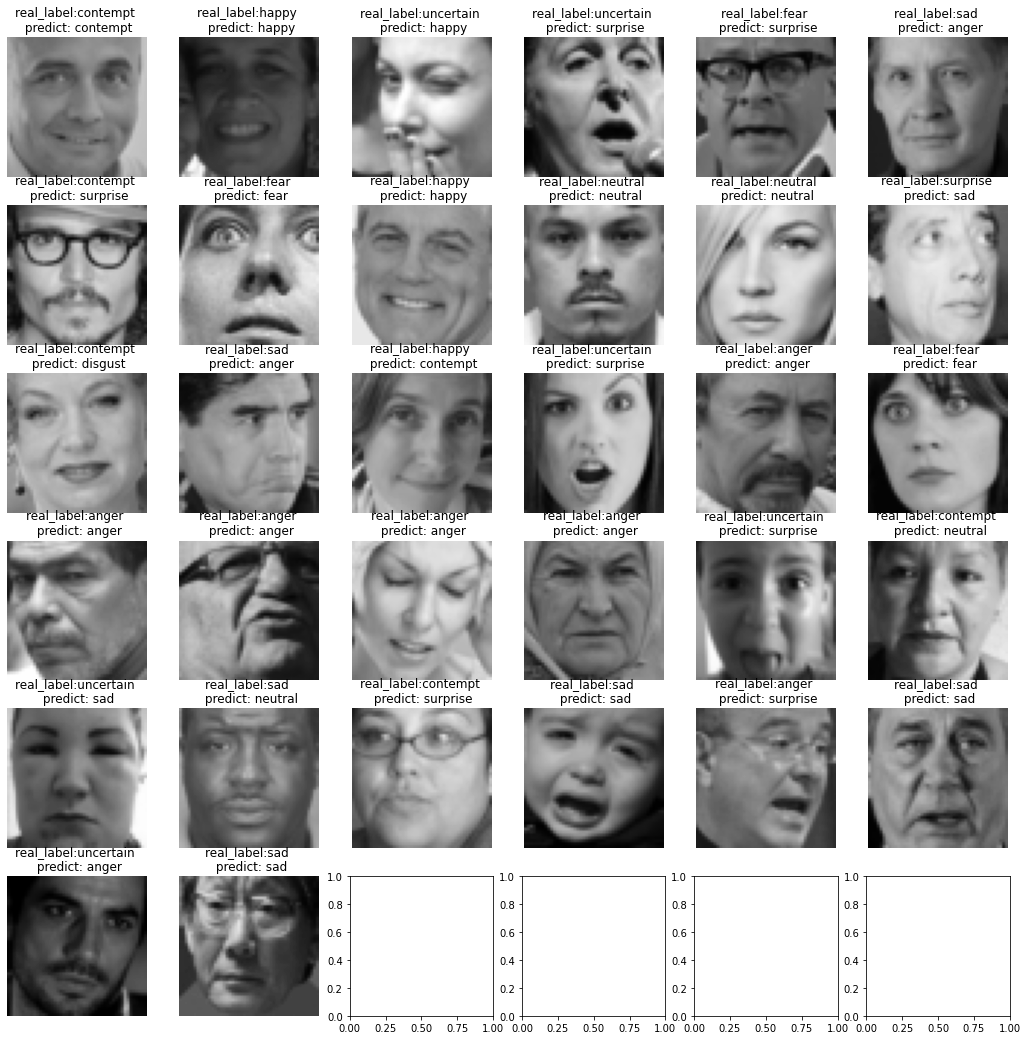

In [82]:
imgs, label = valid_dataflow.next()

rows = 6
cols = 6
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18,18))
for i in range(rows):
    for j in range(cols):        
        if count < len(imgs):
            axes[i, j].axis("off")
            axes[i, j].imshow(imgs[count], cmap='gray', vmin=0, vmax=1)
            emotion_name, _ = class_model.get_emotion(imgs[count])
            axes[i, j].set_title(f'real_label:{emotion_dict[label[count]]} \n predict: {emotion_name}')
            count+=1